## Cell 1
Imports required libraries:
- **pandas** and **numpy** for data manipulation.
- **train_test_split** for splitting data.
- **LogisticRegressionCV** for logistic regression with built-in cross-validation.
- **RandomForestClassifier** (imported here optionally if you want to use it).
- **StandardScaler** for feature scaling.
- **accuracy_score** and **classification_report** to evaluate our models.

In [1]:
import numpy as np
import pandas as pd

# For training/validation split
from sklearn.model_selection import train_test_split

# For classification models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier  # (Optional if you want to try RF later)

# For data preprocessing
from sklearn.preprocessing import StandardScaler

# For evaluation
from sklearn.metrics import accuracy_score, classification_report

# Import necessary libraries for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


## Cell 2
- Defines the base path to the project directory.
- Constructs paths to the training and test CSV files.
- Reads the CSV files (with no headers) into Pandas DataFrames, `train_data` and `test_data`.


In [2]:
# Define base directory and file paths
project_dir = '/Users/adam/Documents/radboud/Data Mining/practicum/DM-ML2425_project'
train_file_path = f'{project_dir}/trainData/53_train.csv'
test_file_path  = f'{project_dir}/trainData/53_test.csv'

# Read in the CSV files with no header row
df_train = pd.read_csv(train_file_path, header=None)
df_test  = pd.read_csv(test_file_path, header=None)

# Function to replace 0 with the mean of the non-zero entries in each column
def replace_zeros_with_mean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()  # avoid mutating the original DataFrame directly
    for col in df.columns:
        # Compute mean excluding zeros
        non_zero_mean = df.loc[df[col] != 0, col].mean()
        # Replace zeros with the computed mean
        df.loc[df[col] == 0, col] = non_zero_mean
    return df

# Apply the function to both training and test data
df_train_no_zeros = replace_zeros_with_mean(df_train)
df_test_no_zeros  = replace_zeros_with_mean(df_test)

# Now df_train_no_zeros and df_test_no_zeros no longer have any zero values;
# zeros have been replaced with their column’s non-zero mean.

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adam/Documents/radboud/Data Mining/practicum/DM-ML2425_project/trainData/53_train.csv'

: 

## Cell 3
1. Creates a target array `y` of length 5000: the first 2500 are labeled 0, and the next 2500 are labeled 1.
2. Prints how many zero-values exist in the training data before scaling.
3. Applies **StandardScaler** to the training data, converting it to `X`.
   - (There's a commented-out line `X = train_data.values` in case you want to skip scaling.)
4. Prints how many zero-values remain after scaling.


In [14]:
# Create target labels:
#  - 0 for the first 2500 records
#  - 1 for the next 2500 records
y = np.array([0] * 2500 + [1] * 2500)

# Check number of zeroes before preprocessing
print("Total count of 0 values before preprocessing:", (df_train == 0).sum().sum())

# Scale the training data using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_train)

# Optional: if you want to skip scaling, you could use:
# X = df_train.values

# Check number of zeroes after preprocessing
print("Total count of 0 values after preprocessing:", (X == 0).sum().sum())


Total count of 0 values before preprocessing: 34798
Total count of 0 values after preprocessing: 0


## Cell 4
- (Optional) You could revert `X` back to the raw data by uncommenting `X = train_data.values`.
- Changes the labels to 1 and 2 (instead of 0 and 1).
- Initializes a **LogisticRegressionCV** model with 5-fold cross-validation, a random seed, and a maximum iteration limit of 1000.
- Splits the scaled features (`X`) and the new labels (`y`) into training and validation sets.
- Fits the model on the training data.
- The line `y_pred = model.predict(X_valid)` is commented out; you could uncomment it to see predictions immediately.


In [15]:
# Example: changing labels to 1 and 2 (instead of 0, 1)
# Be sure to keep track of how these map to original classes
y = np.array([1] * 2500 + [2] * 2500)

# Initialize a LogisticRegression with cross-validation
log_reg_model = LogisticRegressionCV(cv=5, random_state=42, max_iter=1000)

# Split data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fit the logistic regression model
log_reg_model.fit(X_train, y_train)

# If you want, you can comment/uncomment below to see immediate predictions
# y_pred = log_reg_model.predict(X_valid)


LogisticRegressionCV(cv=5, max_iter=1000, random_state=42)


## Cell 5
- We use the model to predict on the validation set, storing the results in `y_pred`.
- We compute and print the accuracy and error rate (1 - accuracy).


In [16]:
# Predict on the validation set
y_pred = log_reg_model.predict(X_valid)

# Calculate accuracy and error rate
acc = accuracy_score(y_valid, y_pred)
err = 1 - acc
print(f"Accuracy: {acc:.2f}")
print(f"Error Rate: {err:.2f}")


Accuracy: 0.85
Error Rate: 0.15


## Cell 6
- Predicts classes for the entire (scaled) **training dataset**.
- Calculates how many samples are predicted to belong to each class and prints the distribution.
- Also computes and prints the proportion of each class (relative frequency).
- Finally, it prints the error rate again for clarity, comparing predictions on the validation set with the true labels.


In [17]:
# Predict on the original training data (scaled)
train_preds = log_reg_model.predict(scaler.transform(df_train.values))

train_class_vals, train_class_counts = np.unique(train_preds, return_counts=True)
for c_val, c_count in zip(train_class_vals, train_class_counts):
    print(f"Class {c_val}: {c_count} records")

# Calculate proportions of each class
class_proportions_train = {
    c_val: c_count / len(train_preds) for c_val, c_count in zip(train_class_vals, train_class_counts)
}
prop_str_train = "-".join([
    f"{class_proportions_train[c_val]:.2f}" for c_val in sorted(class_proportions_train.keys())
])
print(f"Class split: {prop_str_train}")

# Print error rate again for clarity
print(f"Error Rate: {1 - accuracy_score(y_valid, y_pred):.2f}")


Class 1: 2521 records
Class 2: 2479 records
Class split: 0.50-0.50
Error Rate: 0.15


## Cell 7
- Scales the **test dataset** using the previously fitted `StandardScaler`.
- Predicts classes on the test set, then calculates the distribution and proportions of these predicted classes.
- Prints out the distribution summary.
- Writes the test set predictions into a CSV file named `53_output.csv` without headers or indexes.


In [20]:
# Transform the test data
X_test = scaler.transform(df_test.values)

# Predict on the test set
test_preds = log_reg_model.predict(X_test)

# Compute proportions for the test set
test_class_vals, test_class_counts = np.unique(test_preds, return_counts=True)
class_proportions_test = {
    c_val: c_count / len(test_preds) for c_val, c_count in zip(test_class_vals, test_class_counts)
}
prop_str_test = "-".join([
    f"{class_proportions_test[c_val]:.2f}" for c_val in sorted(class_proportions_test.keys())
])
print(f"Class split: {prop_str_test}")

# Save test predictions to a CSV file (no headers, just class labels)
output_path = f"{project_dir}/53_log_reg_output.csv"
pd.DataFrame(test_preds, columns=['Class']).to_csv(output_path, index=False, header=False)


Class split: 0.63-0.37


Accuracy: 0.85
Error Rate: 0.15


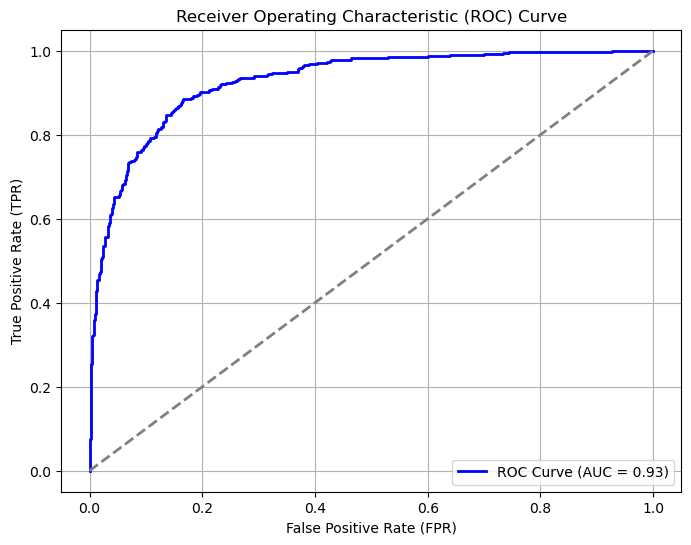

In [19]:
# Import necessary libraries for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred = log_reg_model.predict(X_valid)
y_pred_proba = log_reg_model.predict_proba(X_valid)[:, 1]  # Probabilities for the positive class (label 2)

# Calculate accuracy and error rate
acc = accuracy_score(y_valid, y_pred)
err = 1 - acc
print(f"Accuracy: {acc:.2f}")
print(f"Error Rate: {err:.2f}")

# ROC Curve and AUC
# Map labels back to binary for ROC curve (1 -> 0, 2 -> 1 for positive class)
y_valid_binary = np.where(y_valid == 2, 1, 0)  # Convert class 2 to positive class for ROC
fpr, tpr, thresholds = roc_curve(y_valid_binary, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random chance line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()